In [1]:
import numpy as np
import numba
from numba import njit
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import utils_library.visualization.visualizations as vis
import applications.model_wrapper
import utils_library.post_processing.post as post
import utils_library.configs.draw_config as draw_config
import utils_library.configs.post_config as post_config
import utils_library.configs.keypoints_config as kpts_config
import utils_library.configs.default_config as def_config

In [2]:
def mark_islands(truth_islands) -> (np.ndarray, dict):
    """This creates an array marking separate truth islands in a truth array
    :param truth_islands:2D array bool array
    :return (islands array-of marked islands,island_hierarchy-islands connections dict)"""
    assert len(truth_islands.shape) == 2, "Must be 2D array"
    dim0 = truth_islands.shape[0]
    dim1 = truth_islands.shape[1]
    shape = (dim0 + 1, dim1 + 1)
    islands = np.zeros(shape, dtype=np.uint16)
    island_num = 1
    island_hierarchy = numba.typed.Dict.empty(key_type=numba.types.uint16, value_type=numba.types.uint16)

    for y in range(dim0):
        for x in range(dim1):
            if truth_islands[y, x]:
                iy = y + 1  # to handle array edge case, islands idxs are shifter by one
                ix = x + 1
                above = islands[iy - 1, ix]
                left = islands[iy, ix - 1]
                if not above and not left:
                    islands[iy, ix] = island_num
                    island_hierarchy[island_num] = island_num  # stays None if islands is isolated, or gets changed to master islands later
                    island_num += 1
                elif above and not left:
                    islands[iy, ix] = above
                elif not above and left:
                    islands[iy, ix] = left
                elif above and left:
                    # make above child of left, because above is detected prior to left
                    islands[iy, ix] = above
                    if above != left:
                        island_hierarchy[left] = above
    return islands[1:, 1:], island_hierarchy


#@njit
def sort_island_hierarchy(island_hierarchy):
    """converts the hierarchical island dict to a map to the top level island"""
    compact = numba.typed.Dict.empty(key_type=numba.types.uint16, value_type=numba.types.uint16)
    for child, parent in island_hierarchy.items():
        last_parent = child
        while parent != last_parent:
            last_parent = parent
            parent = island_hierarchy[parent]
        compact[child] = last_parent
    return compact


#@njit
def islands_max(heatmap, islands, island_hierarchy):
    """This returns the maximum value from values for each island from islands"""
    dim0 = islands.shape[0]
    dim1 = islands.shape[1]

    # islands_max=np.zeros(LIMIT_NUM_ISLANDS, dtype=np.float32)-1
    islands_max_dict = numba.typed.Dict.empty(key_type=numba.types.uint16, value_type=numba.types.float32)
    for island_num in set(island_hierarchy.values()):
        islands_max_dict[island_num] = 0  # init here, because that's the only way

    peaks = {}
    for y in range(dim0):
        for x in range(dim1):
            if islands[y, x]:
                island_num = islands[y, x]
                top_island_num = island_hierarchy[island_num]
                if heatmap[y, x] > islands_max_dict[top_island_num]:  #
                    islands_max_dict[top_island_num] = heatmap[y, x]
                    peaks[top_island_num] = (y, x)

    # translate to list view and remove island numbers
    peaks_l = []
    islands_max_l = []
    for k in peaks:
        peaks_l.append(peaks[k])
        islands_max_l.append(islands_max_dict[k])

    return peaks_l, islands_max_l


#@njit
def find_peaks(heatmap, threshold):
    """This takes a 2D heatmap, and returns all peaks on discontinuous regions (islands) for which the heatmap is above the threshold"""
    truth_islands = heatmap > threshold  # get which parts are above the threshold
    segmented_islands, island_hierarchy = mark_islands(truth_islands)  # segment and label the discontinuous regions, returns a island hierarchy dict.
    if not len(island_hierarchy):  # in case nothing found
        return None
    sorted_island_hierarchy = sort_island_hierarchy(island_hierarchy)  # flatten the island hierarchy to point to the top island label
    peaks, island_max = islands_max(heatmap, segmented_islands, sorted_island_hierarchy)  # get the maximum peak location (and value) for each island
    return peaks  # ,island_max


spec = [
        ('field_y', numba.float32[:, :]),
        ('field_x', numba.float32[:, :]),
        ('sum_y', numba.float32),
        ('sum_x', numba.float32),
        # ('num_fields', numba.uint16),
        ]


class Skeleton:
    @classmethod
    def config(cls, KEYPOINTS_DEF, JOINTS_DEF):
        cls.KEYPOINTS_DEF = KEYPOINTS_DEF
        cls.JOINTS_DEF = JOINTS_DEF

    def __init__(self, joint_name, start_kpt_name, end_kpt_name, start_coord, end_coord):
        self.joints = {}
        self.keypoints = {}

        # add first joint
        self.joints[joint_name] = (start_coord, end_coord)
        self.keypoints[start_kpt_name] = start_coord
        self.keypoints[end_kpt_name] = end_coord

    def match_joint(self, joint_name, start_kpt_name, end_kpt_name, start_coord, end_coord):
        if start_kpt_name in self.keypoints and self.keypoints[start_kpt_name] == start_coord:
            self.joints[joint_name] = (start_coord, end_coord)
            self.keypoints[start_kpt_name] = start_coord
            self.keypoints[end_kpt_name] = end_coord
            return True
        if end_kpt_name in self.keypoints and self.keypoints[end_kpt_name] == end_coord:
            self.joints[joint_name] = (start_coord, end_coord)
            self.keypoints[start_kpt_name] = start_coord
            self.keypoints[end_kpt_name] = end_coord
            return True
        return False

    def draw_skeleton(self, joint_draw, kpt_draw):
        """Uses the joint_draw and kpt_draw callables to draw the skeleton
         :param joint_draw: callable with parameters (start_coord,end_coord,joint_name)
         start_coord and end_coord are 2-tuple
         joint_name is str of the joint
         :param kpt_draw: callable with parameters (kpt_coord,kpt_name)
         where kpt_coord is a 2-tuple of keypoint coordinates
         and kpt_name is the keypoint name"""
        for joint_name, (start_coord, end_coord) in self.joints.items():
            joint_draw(start_coord, end_coord, joint_name)
        for kpt_name, kpt_coord in self.keypoints.items():
            kpt_draw(kpt_coord, kpt_name)

In [3]:
class Skeletonizer:
    @classmethod
    def config(cls, KEYPOINTS_DEF, JOINTS_DEF, post_config):
        cls.KEYPOINTS_DEF = KEYPOINTS_DEF
        cls.JOINTS_DEF = JOINTS_DEF
        cls.KEYPOINTS_HEATMAP_THRESHOLD = post_config.KEYPOINTS_HEATMAP_THRESHOLD
        cls.JOINT_ALIGNMENT_THRESHOLD = post_config.JOINT_ALIGNMENT_THRESHOLD

    def __init__(self, kpts, pafs, disp):
        """
        :param pafs: numpy raw pafs output from the trained model
        :param kpts: numpy raw kpts output from the trained model
        """
        self.kpts = kpts
        self.pafs = pafs
        self.disp = disp

        self.LABEL_HEIGHT_RANGE = self.kpts.shape[0] - 1
        self.LABEL_WIDTH_RANGE = self.kpts.shape[1] - 1

    def _localize_potential_kpts(self):
        """This converts the trained model output keypoints heatmaps tensor to coordinates of potential keypoint
        coordinates. find_peaks thresholds the input, segmenting the input into islands of certainty
        and for each island finds the max coords.
        for each keypoint type (from KEYPOINT_DEF) it stores all hits
        :returns a dict of kpts vs their locations"""
        potential_kpts = {}
        for kpt_name, kpt in self.KEYPOINTS_DEF.items():
            kpt_idx = kpt["idx"]
            kpt_heatmap = self.kpts[..., kpt_idx]
            peaks = find_peaks(kpt_heatmap, self.KEYPOINTS_HEATMAP_THRESHOLD)
            potential_kpts[kpt_name] = peaks

        return potential_kpts

    def _create_joints(self, potential_kpts: dict):
        """Creates the best joints from the potential kpts by using the paf vector fields
        all possible joints are scored by alignment with the paf field.
        and then only the best joint matching (bipartite matching) is created according to max alignment score
        and by limiting joints to a 1-to-1 start kpt to end kpt joints
        :param potential_kpts dict of discovered kpts and their coordinates in the processed image
        :returns dict of joint names vs their coords (start,end)"""
        joints = {}
        x_paf_offset = len(self.JOINTS_DEF)
        for joint_name, joint in self.JOINTS_DEF.items():  # work by joints definitions
            start_kpt_name = joint["kpts"][0]
            end_kpt_name = joint["kpts"][1]
            start_kpts = potential_kpts[start_kpt_name]
            end_kpts = potential_kpts[end_kpt_name]
            if not start_kpts or not end_kpts:
                continue
            paf_y = self.pafs[..., joint["idx"]]  # get individual y paf field
            paf_x = self.pafs[..., joint["idx"] + x_paf_offset]
            joint_candidates = self._joint_scoring(start_kpts, end_kpts, paf_y, paf_x, self.disp)  #
            max_num_joints = min(len(start_kpts), len(end_kpts))
            matched_joints = self._joint_matching(joint_candidates, max_num_joints)
            joints[joint_name] = matched_joints
        return joints

    @staticmethod
    def _joint_scoring(start_kpts: list, end_kpts: list, paf_y: np.ndarray, paf_x: np.ndarray, disp):
        """This scores the alignment between all joint start keypoints and joint end keypoints
        using the paf vector field (split to x,y components)
        :param start_kpts list of 2-tuple of ints, joint start coordinates
        :param end_kpts list of 2-tuple of ints, joint end coordinates
        :param paf_y - a field for the y component of the paf
        :param paf_x - a field for the x component of the paf"""
        joint_candidates = []
        for start_kpt in start_kpts:
            for end_kpt in end_kpts:
                alignment, disp_array = kpt_paf_alignment_disp(start_kpt, end_kpt, paf_y, paf_x, disp)
                var = np.var(disp_array)
                t = (var, start_kpt, end_kpt)
                joint_candidates.append(t)
        return joint_candidates

    def _joint_matching(self, joint_candidates: list, num_joints: int):
        """This takes a list of possible joint candidates and makes a bipartite matching of the joints according to
        alignment score, and creating only 1 to 1 connections
        :param joint_candidates list of 3-tuple (alignment,start_kpt,end_kpt), all possible bipartite connections
        :param num_joints max number of possible joints, is min of len(start_kpts),len(end_kpts)
        :returns matched joint list of (start_kpt,end_kpt)"""
        #filtered_candidates = filter(lambda jc: jc[0] > self.JOINT_ALIGNMENT_THRESHOLD, joint_candidates)
        filtered_candidates = joint_candidates
        sorted_candidates = sorted(filtered_candidates, key=lambda x: x[0], reverse=False)  # sort to find highest alignment joints

        matched_start_kpts = []
        matched_end_kpts = []
        count = 0
        matched_joints = []
        for alignment, start_kpt, end_kpt in sorted_candidates:

            if start_kpt not in matched_start_kpts and end_kpt not in matched_end_kpts:  # only match those joints
                # for which no endpoint is already in another joint
                matched_joints.append((start_kpt, end_kpt))
                matched_start_kpts.append(start_kpt)
                matched_end_kpts.append(end_kpt)
                count += 1
            if count >= num_joints:  # num_joints is the maximum possible number of joints, which is the min of number of start kpts or end kpts
                break
        return matched_joints

    def _build_skeletons(self, joint_lists):
        """Builds the complete skeletons from the disconnected joints, by matching endpoints and coordinates between the joints"""
        skeletons = []
        for joint_name, joints_coords in joint_lists.items():
            start_kpt_name = self.JOINTS_DEF[joint_name]["kpts"][0]
            end_kpt_name = self.JOINTS_DEF[joint_name]["kpts"][1]
            for start_coord, end_coord in joints_coords:
                found_match = False
                for skeleton in skeletons:
                    if skeleton.match_joint(joint_name, start_kpt_name, end_kpt_name, start_coord, end_coord):
                        found_match = True
                        break
                if not found_match:
                    new_sk = Skeleton(joint_name, start_kpt_name, end_kpt_name, start_coord, end_coord)
                    skeletons.append(new_sk)
        return skeletons

    def _normalize_joint_coords(self, joint_lists):
        """for all coordinates in joint_lists, scale the coord to 0..1 range"""
        normalized_joint_lists = {}
        for joint_name, joints_coords in joint_lists.items():
            normalized_joints_coords = []
            for start_coord, end_coord in joints_coords:
                normalized_start_coord = self._normalize_coord(start_coord)
                normalized_end_coord = self._normalize_coord(end_coord)
                normalized_joints_coords.append((normalized_start_coord, normalized_end_coord))
            normalized_joint_lists[joint_name] = normalized_joints_coords
        return normalized_joint_lists

    def _normalize_coord(self, coord):
        normalized_y = coord[0] / self.LABEL_HEIGHT_RANGE
        normalized_x = coord[1] / self.LABEL_WIDTH_RANGE
        return (normalized_y, normalized_x)

    def create_skeletons(self):
        """Creates skeletons from the kpts and pafs tensors
        :return list of Skeleton"""
        potential_kpts = self._localize_potential_kpts_NMS()
        joint_lists = self._create_joints(potential_kpts)
        normalized_joint_list = self._normalize_joint_coords(joint_lists)
        skeletons = self._build_skeletons(normalized_joint_list)
        return skeletons
    
    # self added algorithms
    def _localize_potential_kpts_NMS(self):
        """Another implementation of above function by using NMS"""
        potential_kpts = {}
        for kpt_name, kpt in self.KEYPOINTS_DEF.items():
            kpt_idx = kpt["idx"]
            kpt_heatmap = self.kpts[..., kpt_idx]
            peaks = self.find_peaks_NMS(kpt_heatmap, self.KEYPOINTS_HEATMAP_THRESHOLD)
            potential_kpts[kpt_name] = peaks
            
        return potential_kpts
    
    def find_peaks_NMS(self, kpt_heatmap, threshold):
        
        peaks = []
        
        while(1):
            idx_max, value, kpt_heatmap = self.NMS(kpt_heatmap)
            if value < threshold:
                break
            peaks.append(idx_max)
        
        if len(peaks) == 0:
            peaks = None
        return peaks
        
    
    def NMS(self, single_kpt):
        idx_max = np.unravel_index(np.argmax(single_kpt), single_kpt.shape)
        value = single_kpt[idx_max]
        mask = np.zeros_like(single_kpt)
        mask[idx_max] = 18.26
        mask_gaussian = cv2.GaussianBlur(mask, (0,0) , sigmaX=1.7, sigmaY = 1.7)
        masked_single_kpt = single_kpt - mask_gaussian

        return idx_max, value, masked_single_kpt
    
Skeletonizer.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF, post_config)
Skeleton.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF)

post.Skeletonizer.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF, post_config)
post.Skeleton.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF)


In [4]:
class LineVectorIntegral_disp:
    def __init__(self, field_y, field_x, disp):
        self.field_y = field_y
        self.field_x = field_x
        self.disp = disp
        self._init_sums()

    def _init_sums(self):
        self.sum_y = 0.0
        self.sum_x = 0.0
        self.disp_array = []

    def _integrate(self, y, x):
        self.sum_x += self.field_x[y, x]
        self.sum_y += self.field_y[y, x]

    def _integrate_line_high(self, y0, x0, y1, x1):
        dx = x1 - x0
        dy = y1 - y0
        xi = 1
        if dx < 0:
            xi = -1
            dx = -dx
        D = 2 * dx - dy
        x = x0
        for y in range(y0, y1 + 1):
            self._integrate(y, x)
            self.disp_array.append(self.disp[y, x])
            if D > 0:
                x = x + xi
                D = D - 2 * dy
            D = D + 2 * dx

    def _integrate_line_low(self, y0, x0, y1, x1):
        dx = x1 - x0
        dy = y1 - y0
        yi = 1
        if dy < 0:
            yi = -1
            dy = -dy
        D = 2 * dy - dx
        y = y0
        for x in range(x0, x1 + 1):
            self._integrate(y, x)
            self.disp_array.append(self.disp[y, x])
            if D > 0:
                y = y + yi
                D = D - 2 * dx
            D = D + 2 * dy

    def integrate_line(self, start, end):
        """Integrates the y,x fields in a straight line from the start coords to the end coords
        :param start: 2-tuple of uint, line start coords, must be within defined field limits
        :param end: 2-tuple of uint, line end coords, must be within defined field limits
        :return 2-tuple of integral sum of the line on the x and y fields"""
        y0 = start[0]
        x0 = start[1]
        y1 = end[0]
        x1 = end[1]
        self._init_sums()
        if abs(y1 - y0) < abs(x1 - x0): # define use which axis to loop
            if x0 > x1: # keep x axis positive
                self._integrate_line_low(y1, x1, y0, x0)
            else:
                self._integrate_line_low(y0, x0, y1, x1)
        else:
            if y0 > y1: # keep y axis positive
                self._integrate_line_high(y1, x1, y0, x0)
            else:
                self._integrate_line_high(y0, x0, y1, x1)
        return self.sum_y, self.sum_x
    
    def integrate_line_other(self, start, end):
        """Another implementation of integration by using np.linspace, the result seems worse than original version but time cost may be less"""
        self._init_sums()
        
        pot_joint_vec = np.array(end, dtype=np.float32) - np.array(start, dtype=np.float32)
        pot_joint_vec_l = np.sqrt((pot_joint_vec ** 2).sum())
        num = np.round(pot_joint_vec_l).astype(int)
        array = np.linspace(start, end, num, dtype=int)
        for point in array:
            self._integrate(point[0], point[1])
        
        return self.sum_y, self.sum_x

In [5]:
def kpt_paf_alignment_disp(start_kpt, end_kpt, paf_y, paf_x, disp):
    """This creates a score for the PAF field alignment between 2 keypoints
    by doing a vector valued line integral on the straight line between the starting point and the ending,
    on the PAF vector field.
    :param start_kpt - 2-tuple for the starting point of a potential joint
    :param end_kpt - 2-tuple for the ending
    :param paf_y - a field for the y component of the paf
    :param paf_x - a field for the x component of the paf"""
    pot_joint_vec = np.array(end_kpt, dtype=np.float32) - np.array(start_kpt, dtype=np.float32)
    pot_joint_vec_l = np.sqrt((pot_joint_vec ** 2).sum())
    if pot_joint_vec_l == 0.0:  # handle zero length
        return 0.5, 1  # assuming that if kpts overlap they are somewhat related
    pot_joint_unit_vec = np.divide(pot_joint_vec, pot_joint_vec_l)

    li = LineVectorIntegral_disp(paf_y, paf_x, disp)
    paf_sum = li.integrate_line(start_kpt, end_kpt)  # get vector sum of the PAF field
    paf_sum_np = np.array(paf_sum, dtype=np.float32)

    paf_samples_count = (np.abs(pot_joint_vec)).max() + 1.0  # calc number of vectors in paf sum
    average_paf = paf_sum_np / paf_samples_count  # average across length of line

    alignment = np.sum(pot_joint_unit_vec * average_paf)  # calc the alignment
    return alignment, li.disp_array

In [6]:
def preprocess_img(img):
    """
    This function implements the preprocessing of input image.
    Input original img, it will:
    1. add newaxis to first dimension
    2. fix image height to 368 and proportionally resize image width
    3. normalize to 0...1 by dividing 255
    """
    inHeight = img.shape[0]
    inWidth = img.shape[1]
    frameHeight = 368
    frameWidth = round(frameHeight/inHeight * inWidth)
    
    input_img = tf.image.resize(img, (frameHeight, frameWidth))
    input_img = tf.image.convert_image_dtype(input_img, dtype=tf.float32)
    
    input_img = input_img[tf.newaxis, ...]

    return input_img

In [22]:
## configs
#model_path = "./trained_models/model11_test-15Sun1219-2101/"
model_path = "./trained_models/mobilenet_model_COCO_ss/"
img_path = "./self_dataset/RGBD_Dataset/RGBD_imgs/left_Explorer_HD720_SN15385_19-35-37.png"
disp_flag = 1

# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

In [8]:
# loading model and check architecture
model = tf.keras.models.load_model(model_path)

In [23]:
# loading images and do preprocessing
img_full = plt.imread(img_path)
img_rgb = img_full[...,:3]
disp = img_full[...,3]
input_img = preprocess_img(img_rgb)
output_img = (img_rgb * 255).astype('uint8')

In [24]:
pafs, kpts = model.predict(input_img)

# Post-process

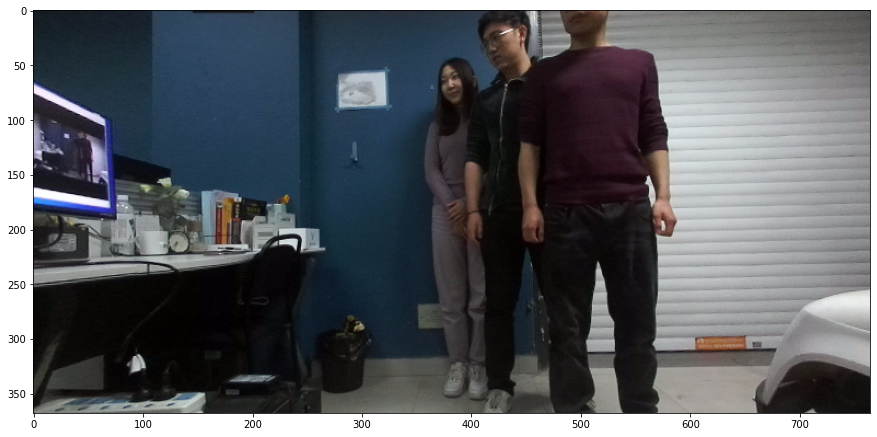

In [25]:
plt.figure(figsize=[15,15])
plt.imshow(input_img[0,...])

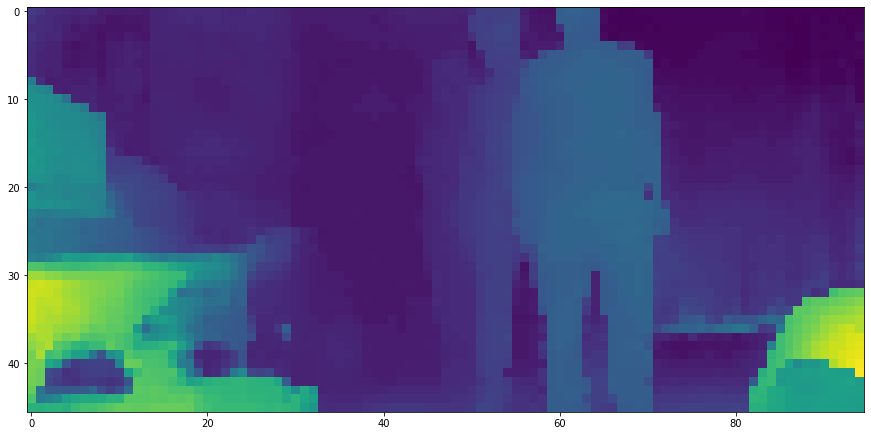

In [26]:
disp = cv2.resize(disp, dsize=(95,46))
plt.figure(figsize=[15,15])
plt.imshow(disp)

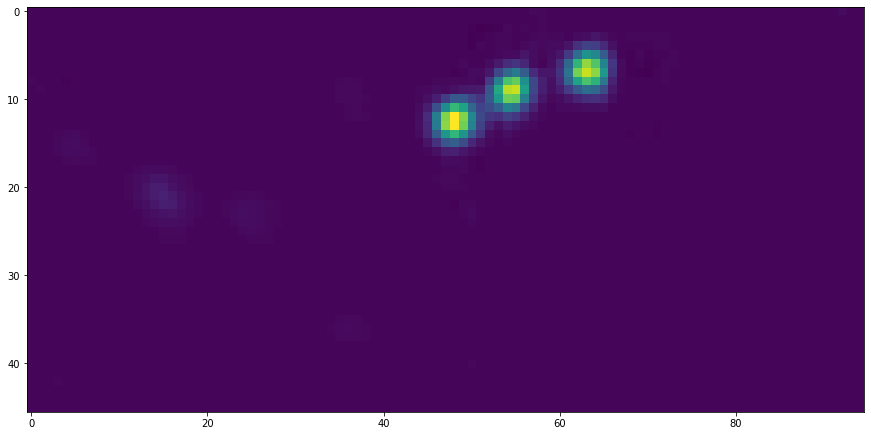

In [27]:
plt.figure(figsize=[15,15])
single_paf = kpts[0,...,1]
#single_paf = cv2.resize(single_paf, dsize=(1526,734))
plt.imshow(single_paf)

In [28]:
if disp_flag == 0:
    skeletonizer = post.Skeletonizer(kpts[0], pafs[0])
else:
    skeletonizer = Skeletonizer(kpts[0], pafs[0], disp)
potential_kpts = skeletonizer._localize_potential_kpts_NMS()
joint_lists = skeletonizer._create_joints(potential_kpts)
normalized_joint_list = skeletonizer._normalize_joint_coords(joint_lists)
skeletons = skeletonizer._build_skeletons(normalized_joint_list)

In [29]:
potential_kpts

{'nose': [(8, 47), (4, 52)],
 'sternum': [(12, 48), (9, 55), (7, 63)],
 'Rshoulder': [(13, 46), (6, 69), (10, 51)],
 'Relbow': [(18, 45), (14, 71), (18, 50)],
 'Rwrist': [(21, 71), (22, 48)],
 'Rhip': [(22, 68), (23, 47), (22, 52)],
 'Rknee': [(33, 48), (32, 53), (36, 69)],
 'Rankle': [(40, 48), (42, 53)],
 'Reye': [(8, 47), (3, 51)],
 'Rear': [(9, 46)],
 'Lshoulder': [(7, 58), (12, 50)],
 'Lelbow': [(16, 56), (18, 50)],
 'Lwrist': [(22, 57), (22, 50)],
 'Lhip': [(23, 49), (22, 55), (22, 60)],
 'Lknee': [(32, 50), (32, 60), (32, 54)],
 'Lankle': [(40, 50), (42, 61)],
 'Leye': [(3, 52), (7, 48)],
 'Lear': [(3, 55), (8, 49)]}

In [30]:
skeleton_drawer = vis.SkeletonDrawer(output_img, draw_config)
for skeleton in skeletons:
    skeleton.draw_skeleton(skeleton_drawer.joint_draw, skeleton_drawer.kpt_draw)

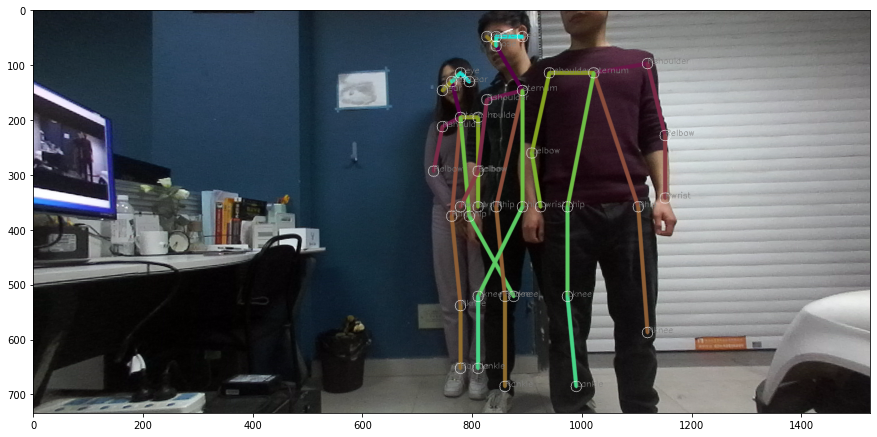

In [31]:
plt.figure(figsize=[15,15])
plt.imshow(output_img)

# Using disp information

In [32]:
start_kpts = potential_kpts['Rhip']
end_kpts = potential_kpts['Rknee']
paf_y = pafs[0,...,5]
paf_x = pafs[0,...,22]

array = []
start_kpt = start_kpts[0]
end_kpt = end_kpts[0]
for start_kpt in start_kpts:
    for end_kpt in end_kpts:
        print("start_kpt:", start_kpt, ";end_kpt:", end_kpt)
        alignment, disp_array = kpt_paf_alignment_disp(start_kpt, end_kpt, paf_y, paf_x, disp)
        print("alignment_score:",alignment)
        print("disp_var:", np.var(disp_array)) 


start_kpt: (22, 68) ;end_kpt: (33, 48)
alignment_score: 0.10724939
disp_var: 0.0014784684
start_kpt: (22, 68) ;end_kpt: (32, 53)
alignment_score: 0.10207492
disp_var: 0.0013675455
start_kpt: (22, 68) ;end_kpt: (36, 69)
alignment_score: 0.70649683
disp_var: 1.686207e-05
start_kpt: (23, 47) ;end_kpt: (33, 48)
alignment_score: 0.8491473
disp_var: 4.067094e-06
start_kpt: (23, 47) ;end_kpt: (32, 53)
alignment_score: 0.375231
disp_var: 7.6568125e-05
start_kpt: (23, 47) ;end_kpt: (36, 69)
alignment_score: 0.13079898
disp_var: 0.0008777657
start_kpt: (22, 52) ;end_kpt: (33, 48)
alignment_score: 0.3399367
disp_var: 0.000121917634
start_kpt: (22, 52) ;end_kpt: (32, 53)
alignment_score: 0.642189
disp_var: 0.0
start_kpt: (22, 52) ;end_kpt: (36, 69)
alignment_score: 0.11971486
disp_var: 0.00058903487


In [47]:
start_kpts = potential_kpts['Lhip']
end_kpts = potential_kpts['Lknee']
paf_y = pafs[0,...,5]
paf_x = pafs[0,...,22]

array = []
start_kpt = start_kpts[0]
end_kpt = end_kpts[2]

print("start_kpt:", start_kpt, ";end_kpt:", end_kpt)
alignment, disp_array = kpt_paf_alignment_disp(start_kpt, end_kpt, paf_y, paf_x, disp)
print("alignment_score:",alignment)
print("disp_array:", disp_array) 

start_kpt: (23, 49) ;end_kpt: (32, 54)
alignment_score: 0.36436263
disp_array: [0.18431373, 0.1882353, 0.1882353, 0.19215687, 0.19215687, 0.1955445, 0.19215687, 0.19607843, 0.19607843, 0.2]


In [48]:
disp_grad = []
for idx in range(len(disp_array)-1):
    disp_grad.append(abs(disp_array[idx+1] - disp_array[idx]))

In [52]:
penpose-Implementation/未命名.ipynb

TypeError: 'numpy.float32' object cannot be interpreted as an integer

In [51]:
disp_grad[disp_grad > 0.003] = 1

TypeError: '>' not supported between instances of 'list' and 'float'